In [ ]:
#https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [4]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import time
import string
import re
st = string.punctuation
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
stopword = nltk.corpus.stopwords.words('english')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import numpy as np
from keras import layers
from keras.initializers import Constant
from keras.models import Sequential, Model
from keras.layers import Dense,LSTM,Dropout, Input, Conv1D
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs



*  Bring in Data
*  Remove where there is no description
* Combine Headline and ShortDescription into 'headlineDesc'



In [6]:
def load_data(file_path):
    df = pd.read_json(file_path, lines = True)
    df['category'] = pd.Categorical(df['category'])
    df = df[df["short_description"] != ""]
    df['headlineDesc'] = df['headline']+ ' ' + df['short_description']
    return df[["headlineDesc", "category"]]

df = load_data('News_Category_Dataset_v2.json')
df.head()

,headlineDesc,category
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 5...,ENTERTAINMENT
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT


In [6]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 41
category
ARTS                863
ARTS & CULTURE     1339
BLACK VOICES       4122
BUSINESS           5077
COLLEGE             921
COMEDY             4417
CRIME              2675
CULTURE & ARTS     1019
DIVORCE            3426
EDUCATION           892
ENTERTAINMENT     13470
ENVIRONMENT        1321
FIFTY              1042
FOOD & DRINK       6217
GOOD NEWS          1039
GREEN              2046
HEALTHY LIVING     5265
HOME & LIVING      4192
IMPACT             3061
LATINO VOICES      1021
MEDIA              2275
MONEY              1706
PARENTING          8676
PARENTS            3556
POLITICS          29578
QUEER VOICES       5570
RELIGION           1858
SCIENCE            1775
SPORTS             4221
STYLE              1567
STYLE & BEAUTY     9637
TASTE              1940
TECH               2081
THE WORLDPOST      3664
TRAVEL             9408
WEDDINGS           3651
WEIRD NEWS         2209
WELLNESS          17825
WOMEN              3102
WORLD NEWS         2175
WORLDPOST 



*   Create Category Id
*   Clean up text:
  * Remove Punctuation
  * Split
  * Remove Stopwords





In [7]:
col = ['category', 'headlineDesc']
df = df[col]
df = df[pd.notnull(df['headlineDesc'])]
df.columns = ['category', 'headlineDesc']
df['category_id'] = df['category'].factorize()[0]
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)


#https://towardsdatascience.com/nlp-in-python-data-cleaning-6313a404a470
#https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
def remove_punctuation(text,st):
    no_punct=[words for words in text if words not in st]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

def tokenize(text):
    #convert string to list
    split=re.split("\W+",text) 
    return split

def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text

def stem_lem(text):
  ## Stemming (remove -ing, -ly, ...) ## Lemmatisation (convert the word into root word)
  ps = nltk.stem.porter.PorterStemmer()
  lst_text = [ps.stem(word) for word in text]
  lem = nltk.stem.wordnet.WordNetLemmatizer()
  lst_text = [lem.lemmatize(word) for word in lst_text]
  return lst_text

df['mainDesc']=df['headlineDesc'].apply(lambda x: remove_punctuation(x,st))
df['mainDesc']=df['mainDesc'].apply(lambda x: tokenize(x.lower()))
df['mainDesc'] = df['mainDesc'].apply(lambda x: remove_stopwords(x))
df['mainDesc'] = df['mainDesc'].apply(lambda x: stem_lem(x))
df['main'] = df['mainDesc'].apply(lambda x: ' '.join(str(x) for x in x))
df.head()

,category,headlineDesc,category_id,mainDesc,main
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,0,"[2, mass, shoot, texa, last, week, 1, tv, left...",2 mass shoot texa last week 1 tv left husband ...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,1,"[smith, join, diplo, nicki, jam, 2018, world, ...",smith join diplo nicki jam 2018 world cup offi...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...,1,"[hugh, grant, marri, first, time, age, 57, act...",hugh grant marri first time age 57 actor longt...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,1,"[jim, carrey, blast, castrato, adam, schiff, d...",jim carrey blast castrato adam schiff democrat...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,1,"[julianna, marguli, use, donald, trump, poop, ...",julianna marguli use donald trump poop bag pic...


**NO  REWEIGHTING**
- Bag of Words Approach

In [8]:
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7)
features = tfidfconverter.fit_transform(df.main).toarray()
labels = df.category_id
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

**LOGISITIC REGRESSION**

In [9]:
start_time = time.time()
lr = LogisticRegression(C=5.0, max_iter=200, random_state=1, solver='lbfgs', multi_class='ovr')
lr.fit(X_train, y_train)
end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f'Epoch Time: {epoch_mins}m {epoch_secs}s')    

Epoch Time: 14m 6s


In [10]:
score = lr.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.5422175605178172


In [11]:
y_pred = lr.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 233   34    4 ...    0    0    0]
 [  18 1628    0 ...    2    2    5]
 [  15   18   45 ...    1    1    0]
 ...
 [   4    8    0 ...  107    0    0]
 [   3    9    3 ...    1   59    2]
 [   0   32    0 ...    2    1   50]]
              precision    recall  f1-score   support

           0       0.46      0.43      0.44       537
           1       0.46      0.62      0.53      2625
           2       0.31      0.11      0.16       428
           3       0.33      0.21      0.26       611
           4       0.63      0.83      0.72      5867
           5       0.27      0.15      0.19       441
           6       0.44      0.26      0.32       838
           7       0.32      0.22      0.26       595
           8       0.47      0.29      0.36       864
           9       0.74      0.59      0.66      1131
          10       0.54      0.52      0.53       849
          11       0.41      0.38      0.39       982
          12       0.59      0.72      0.65      1894
          13   

**LINEAR SVC**

In [12]:
start_time = time.time()
ls = LinearSVC()
ls.fit(X_train, y_train)
end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f'Epoch Time: {epoch_mins}m {epoch_secs}s')    

Epoch Time: 0m 16s


In [13]:
score = ls.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.5417207209693892


In [14]:
y_pred = ls.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 253   30    2 ...    1    0    0]
 [  23 1641    1 ...    4    1    4]
 [  16   19   30 ...    1    3    0]
 ...
 [   5    8    0 ...  111    0    0]
 [   4    7    2 ...    1   51    3]
 [   1   33    0 ...    1    1   49]]
              precision    recall  f1-score   support

           0       0.43      0.47      0.45       537
           1       0.47      0.63      0.54      2625
           2       0.28      0.07      0.11       428
           3       0.33      0.16      0.22       611
           4       0.64      0.83      0.72      5867
           5       0.28      0.11      0.16       441
           6       0.47      0.24      0.32       838
           7       0.33      0.20      0.25       595
           8       0.54      0.25      0.34       864
           9       0.77      0.60      0.68      1131
          10       0.53      0.55      0.54       849
          11       0.41      0.38      0.39       982
          12       0.57      0.72      0.64      1894
          13   

**RANDOM FOREST**

In [15]:
start_time = time.time()
rf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
rf.fit(X_train, y_train)
end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f'Epoch Time: {epoch_mins}m {epoch_secs}s')    

Epoch Time: 0m 33s


In [16]:
score = rf.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.16862182229705486


In [17]:
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       537
           1       0.00      0.00      0.00      2625
           2       0.00      0.00      0.00       428
           3       0.00      0.00      0.00       611
           4       0.16      1.00      0.28      5867
           5       0.00      0.00      0.00       441
           6       0.00      0.00      0.00       838
           7       0.00      0.00      0.00       595
           8       0.00      0.00      0.00       864
           9       0.00      0.00      0.00      1131
          10       0.00      0.00      0.00       849
          11       0.00      0.00      0.00       982
          12       1.00      0.00      0.00      1894
          13       0.00      0.00      0.00       484
          14       0.00      0.00      0.00       409
          15   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**TOKENIZER**

In [18]:
# tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.main)
X = tokenizer.texts_to_sequences(df.main)
df['words'] = X
vocab_size = len(tokenizer.word_index) + 1
# delete some empty and short data
df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 5]

In [19]:
from keras.preprocessing import sequence
maxlen = 50
X = list(sequence.pad_sequences(df.words, maxlen=maxlen))
categories = df.groupby('category').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['category'].apply(lambda x: category_int[x])

word_index = tokenizer.word_index

EMBEDDING_DIM = 100

embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s unique tokens.' % len(word_index))
print('Total %s word vectors.' % len(embeddings_index))

Found 79516 unique tokens.
Total 400000 word vectors.


In [20]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

X = np.array(X)
Y = np_utils.to_categorical(list(df.c2id))

# and split to training set and validation set

seed = 29
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [21]:
#from keras.backend import clear_session
#clear_session()
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=3))
model.add(layers.Bidirectional(LSTM(10, dropout=0.2)))
model.add(Dropout(0.5))
model.add(Dense(41, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

model.fit(x_train, y_train, epochs=20, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           7951700   
                                                                 
 conv1d (Conv1D)             (None, 50, 64)            19264     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 20)               6000      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 41)                8

In [24]:
from keras.backend import clear_session
clear_session()

inp = Input(shape=(maxlen,), dtype='int32')
embedding = embedding_layer(inp)
stacks = []
for kernel_size in [3, 4, 5, 6]:
    conv = layers.Conv1D(64, kernel_size, padding='same', activation='relu', strides=1)(embedding)
    pool = layers.MaxPooling1D(pool_size=3)(conv)
    drop = Dropout(0.3)(pool)
    stacks.append(drop)

merged = layers.Concatenate()(stacks)
flatten = layers.Flatten()(merged)
drop = Dropout(0.3)(flatten)
outp = Dense(len(int_category), activation='softmax')(drop)

TextCNN = Model(inputs=inp, outputs=outp)
TextCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

TextCNN.summary()

textcnn_history = TextCNN.fit(x_train, 
                              y_train, 
                              batch_size=64, 
                              epochs=20, 
                              validation_data=(x_val, y_val))

scores = TextCNN.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 100)      7951700     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 50, 64)       19264       ['embedding[2][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 50, 64)       25664       ['embedding[2][0]']              
                                                                                              

In [37]:
from keras.backend import clear_session
clear_session()

from tensorflow.keras import models
X = np.array(X)
Y = np_utils.to_categorical(list(df.c2id))

# and split to training set and validation set

seed = 29
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)

## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
inp = Input(shape=(maxlen,), dtype='int32')
embedding_layer = layers.Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

## embedding
x = embedding_layer(inp)
## apply attention
x = attention_layer(x, neurons=50)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=50, dropout=0.5, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=50, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(41, activation='softmax')(x)
## compile
model = models.Model(inp, y_out)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 100)      7951700     ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 100, 50)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 100, 50)      2550        ['permute[0][0]']                
                                                                                              

In [38]:
ltsm_history = model.fit(x_train, 
                              y_train, 
                              batch_size=128, 
                              epochs=20, 
                              validation_data=(x_val, y_val))

scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/20
1132/1132 [==============================] - 25s 18ms/step - loss: 2.7319 - accuracy: 0.2957 - val_loss: 2.3261 - val_accuracy: 0.3873
Epoch 2/20
1132/1132 [==============================] - 19s 17ms/step - loss: 2.3204 - accuracy: 0.3854 - val_loss: 2.1570 - val_accuracy: 0.4225
Epoch 3/20
1132/1132 [==============================] - 19s 17ms/step - loss: 2.1915 - accuracy: 0.4147 - val_loss: 2.0526 - val_accuracy: 0.4479
Epoch 4/20
1132/1132 [==============================] - 19s 17ms/step - loss: 2.1154 - accuracy: 0.4332 - val_loss: 1.9832 - val_accuracy: 0.4638
Epoch 5/20
1132/1132 [==============================] - 19s 17ms/step - loss: 2.0497 - accuracy: 0.4474 - val_loss: 1.9193 - val_accuracy: 0.4792
Epoch 6/20
1132/1132 [==============================] - 19s 16ms/step - loss: 2.0014 - accuracy: 0.4594 - val_loss: 1.8740 - val_accuracy: 0.4894
Epoch 7/20
1132/1132 [==============================] - 19s 17ms/step - loss: 1.9618 - accuracy: 0.4686 - val_loss: 1.8613 -

**REWEIGHTING - UNDERSAMPLER**

In [8]:
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7)
X = tfidfconverter.fit_transform(df.main).toarray()
y = df.category_id

In [ ]:
# example of oversampling a multi-class classification dataset
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)
# transform the dataset
# from imblearn.over_sampling import SMOTE
# oversample = SMOTE(random_state=1)
# X, y = oversample.fit_resample(X, y)

Class=0, n=863 (2.439%)
Class=1, n=863 (2.439%)
Class=2, n=863 (2.439%)
Class=3, n=863 (2.439%)
Class=4, n=863 (2.439%)
Class=5, n=863 (2.439%)
Class=6, n=863 (2.439%)
Class=7, n=863 (2.439%)
Class=8, n=863 (2.439%)
Class=9, n=863 (2.439%)
Class=10, n=863 (2.439%)
Class=11, n=863 (2.439%)
Class=12, n=863 (2.439%)
Class=13, n=863 (2.439%)
Class=14, n=863 (2.439%)
Class=15, n=863 (2.439%)
Class=16, n=863 (2.439%)
Class=17, n=863 (2.439%)
Class=18, n=863 (2.439%)
Class=19, n=863 (2.439%)
Class=20, n=863 (2.439%)
Class=21, n=863 (2.439%)
Class=22, n=863 (2.439%)
Class=23, n=863 (2.439%)
Class=24, n=863 (2.439%)
Class=25, n=863 (2.439%)
Class=26, n=863 (2.439%)
Class=27, n=863 (2.439%)
Class=28, n=863 (2.439%)
Class=29, n=863 (2.439%)
Class=30, n=863 (2.439%)
Class=31, n=863 (2.439%)
Class=32, n=863 (2.439%)
Class=33, n=863 (2.439%)
Class=34, n=863 (2.439%)
Class=35, n=863 (2.439%)
Class=36, n=863 (2.439%)
Class=37, n=863 (2.439%)
Class=38, n=863 (2.439%)
Class=39, n=863 (2.439%)
Class=40, 

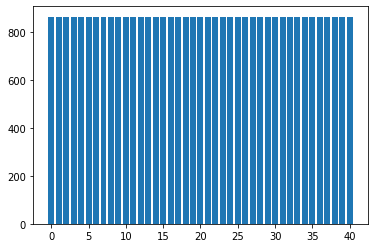

In [ ]:
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**LOGISTIC REGRESSION**

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

start_time = time.time()
lr = LogisticRegression(C=1.0, max_iter=100, random_state=1, solver='lbfgs', multi_class='ovr')
lr.fit(X_train, y_train)
end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f'Epoch Time: {epoch_mins}m {epoch_secs}s')    

Epoch Time: 1m 31s


In [ ]:
score = lr.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.39027836653949416


**LINEAR SVC**

In [ ]:
start_time = time.time()
ls = LinearSVC()
ls.fit(X_train, y_train)
end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f'Epoch Time: {epoch_mins}m {epoch_secs}s')    

Epoch Time: 0m 2s


In [ ]:
score = ls.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.361028684470821


**OVERSAMPLING**

In [ ]:
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7)
X = tfidfconverter.fit_transform(df.main).toarray()
y = df.category_id

# transform the dataset
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=1)
X, y = oversample.fit_resample(X, y)

In [ ]:
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Above fails .. try with Tokenizing .. 

In [8]:
# tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.main)
X = tokenizer.texts_to_sequences(df.main)
df['words'] = X
vocab_size = len(tokenizer.word_index) + 1
# delete some empty and short data
df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 5]

In [65]:
from keras.preprocessing import sequence
maxlen = 50
X = list(sequence.pad_sequences(df.words, maxlen=maxlen))
categories = df.groupby('category').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['category'].apply(lambda x: category_int[x])

word_index = tokenizer.word_index

EMBEDDING_DIM = 100

embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s unique tokens.' % len(word_index))
print('Total %s word vectors.' % len(embeddings_index))

Found 79503 unique tokens.
Total 400000 word vectors.


In [67]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

X = np.array(X)
Y = np_utils.to_categorical(list(df.c2id))

In [69]:
from pandas import read_csv
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

oversample = SMOTE()
X, y = oversample.fit_resample(X, Y)

In [71]:
#Y = np_utils.to_categorical(y)

seed = 29
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

In [72]:
from keras.backend import clear_session
clear_session()
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=3))
model.add(layers.Bidirectional(LSTM(10, dropout=0.2)))
model.add(Dropout(0.5))
model.add(Dense(41, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

model.fit(x_train, y_train, epochs=20, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(x_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           7950400   
                                                                 
 conv1d (Conv1D)             (None, 50, 64)            19264     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 20)               6000      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 41)                8